In [1]:
#@title
import concurrent.futures
import collections
import dataclasses
import hashlib
import itertools
import json
import math
import os
import pathlib
import random
import re
import string
import time
import urllib.request

import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import requests
import tqdm

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds

#### Flickr30k

In [2]:
def flickr30k(path='Dataset'):
  path = pathlib.Path(path)
    
  captions = (path/"Flickr30k_text/Flickr30k.token.txt").read_text().splitlines()
  captions = (line.split('\t') for line in captions)
  captions = ((fname.split('#')[0], caption) for (fname, caption) in captions)

  cap_dict = collections.defaultdict(list)
  for fname, cap in captions:
    cap_dict[fname].append(cap)

  train_files = (path/'Flickr30k_text/Flickr_30k.trainImages.txt').read_text().splitlines()
  train_captions = [(str(path/'Flicker30k_Dataset'/fname), cap_dict[fname]) for fname in train_files]

  test_files = (path/'Flickr30k_text/Flickr_30k.testImages.txt').read_text().splitlines()
  test_captions = [(str(path/'Flicker30k_Dataset'/fname), cap_dict[fname]) for fname in test_files]

  train_ds = tf.data.experimental.from_list(train_captions)
  test_ds = tf.data.experimental.from_list(test_captions)

  return train_ds, test_ds

#### Download the dataset

In [3]:
train_raw, test_raw = flickr30k()

In [4]:
train_raw.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(5,), dtype=tf.string, name=None))

In [5]:
for ex_path, ex_captions in train_raw.take(1):
  print(ex_path)
  print(ex_captions)

tf.Tensor(b'Dataset\\Flicker30k_Dataset\\1000092795.jpg', shape=(), dtype=string)
tf.Tensor(
[b'Two young guys with shaggy hair look at their hands while hanging out in the yard .'
 b'Two young  White males are outside near many bushes .'
 b'Two men in green shirts are standing in a yard .'
 b'A man in a blue shirt standing in a garden .'
 b'Two friends enjoy time spent together .'], shape=(5,), dtype=string)


In [6]:
IMAGE_SHAPE=(224, 224, 3)
mobilenet = tf.keras.applications.MobileNetV3Small(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    include_preprocessing=True)
mobilenet.trainable=False

Here's a function to load an image and resize it for the model:

In [7]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])
    return img

The model returns a feature map for each image in the input batch:

In [8]:
test_img_batch = load_image(ex_path)[tf.newaxis, :]

print(test_img_batch.shape)
print(mobilenet(test_img_batch).shape)

(1, 224, 224, 3)
(1, 7, 7, 576)


**Setup the text tokenizer/vectorizer**

In [9]:
def standardize(s):
  s = tf.strings.lower(s)
  s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '')
  s = tf.strings.join(['[START]', s, '[END]'], separator=' ')
  return s

In [10]:
# Use the top 5000 words for a vocabulary.
vocabulary_size = 10000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    ragged=True)
# Learn the vocabulary from the caption data.

In [11]:
tokenizer.adapt(train_raw.map(lambda fp,txt: txt).unbatch().batch(1024))

In [12]:
tokenizer.get_vocabulary()[:10]

['', '[UNK]', 'a', '[START]', '[END]', 'in', 'the', 'on', 'and', 'man']

In [13]:
t = tokenizer([['a cat in a hat'], ['a robot dog']])
t

<tf.RaggedTensor [[3, 2, 677, 5, 2, 63, 4], [3, 2, 3126, 34, 4]]>

In [14]:
# Create mappings for words to indices and indices to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [15]:
w = index_to_word(t)
w.to_list()

[[b'[START]', b'a', b'cat', b'in', b'a', b'hat', b'[END]'],
 [b'[START]', b'a', b'robot', b'dog', b'[END]']]

In [16]:
tf.strings.reduce_join(w, separator=' ', axis=-1).numpy()

array([b'[START] a cat in a hat [END]', b'[START] a robot dog [END]'],
      dtype=object)

### Prepare the datasets

In [17]:
def match_shapes(images, captions):
  caption_shape = einops.parse_shape(captions, 'b c')
  captions = einops.rearrange(captions, 'b c -> (b c)')
  images = einops.repeat(
      images, 'b ... -> (b c) ...',
      c = caption_shape['c'])
  return images, captions

In [18]:
for ex_paths, ex_captions in train_raw.batch(32).take(1):
  break

print('image paths:', ex_paths.shape)
print('captions:', ex_captions.shape)
print()

ex_paths, ex_captions = match_shapes(images=ex_paths, captions=ex_captions)

print('image_paths:', ex_paths.shape)
print('captions:', ex_captions.shape)


image paths: (32,)
captions: (32, 5)

image_paths: (160,)
captions: (160,)


In [19]:
def prepare_txt(imgs, txts):
  tokens = tokenizer(txts)

  input_tokens = tokens[..., :-1]
  label_tokens = tokens[..., 1:]
  return (imgs, input_tokens), label_tokens

In [20]:
def prepare_dataset(ds, tokenizer, batch_size=32, shuffle_buffer=1000):
  # Load the images and make batches.
  ds = (ds
        .shuffle(10000)
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  def to_tensor(inputs, labels):
    (images, in_tok), out_tok = inputs, labels
    return (images, in_tok.to_tensor()), out_tok.to_tensor()

  return (ds
          .map(match_shapes, tf.data.AUTOTUNE)
          .unbatch()
          .shuffle(shuffle_buffer)
          .batch(batch_size)
          .map(prepare_txt, tf.data.AUTOTUNE)
          .map(to_tensor, tf.data.AUTOTUNE)
          )

You could install the feature extractor in your model and train on the datasets like this:

In [21]:
train_ds = prepare_dataset(train_raw, tokenizer)
train_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [22]:
test_ds = prepare_dataset(test_raw, tokenizer)
test_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

### Cache the image features

In [23]:
def save_dataset(ds, save_path, image_model, tokenizer, shards=10, batch_size=32):
  # Load the images and make batches.
  ds = (ds
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  # Run the feature extractor on each batch
  # Don't do this in a .map, because tf.data runs on the CPU. 
  def gen():
    for (images, captions) in tqdm.tqdm(ds): 
      feature_maps = image_model(images)

      feature_maps, captions = match_shapes(feature_maps, captions)
      yield feature_maps, captions

  # Wrap the generator in a new tf.data.Dataset.
  new_ds = tf.data.Dataset.from_generator(
      gen,
      output_signature=(
          tf.TensorSpec(shape=image_model.output_shape),
          tf.TensorSpec(shape=(None,), dtype=tf.string)))

  # Apply the tokenization 
  new_ds = (new_ds
            .map(prepare_txt, tf.data.AUTOTUNE)
            .unbatch()
            .shuffle(1000))

  # Save the dataset into shard files.
  def shard_func(i, item):
    return i % shards
  new_ds.enumerate().save(save_path, shard_func=shard_func)

def load_dataset(save_path, batch_size=32, shuffle=1000, cycle_length=2):
  def custom_reader_func(datasets):
    datasets = datasets.shuffle(1000)
    return datasets.interleave(lambda x: x, cycle_length=cycle_length)
  
  ds = tf.data.Dataset.load(save_path, reader_func=custom_reader_func)

  def drop_index(i, x):
    return x

  ds = (ds
        .map(drop_index, tf.data.AUTOTUNE)
        .shuffle(shuffle)
        .padded_batch(batch_size)
        .prefetch(tf.data.AUTOTUNE))
  return ds

In [24]:
save_dataset(train_raw, 'train_cache', mobilenet, tokenizer)
save_dataset(test_raw, 'test_cache', mobilenet, tokenizer)

798it [26:49,  2.02s/it]
196it [06:22,  1.95s/it]


 </section>


## Data ready for training

After those preprocessing steps, here are the datasets:

In [25]:
train_ds = load_dataset('train_cache')
test_ds = load_dataset('test_cache')

In [26]:
train_ds.element_spec

((TensorSpec(shape=(None, 7, 7, 576), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [27]:
for (inputs, ex_labels) in train_ds.take(1):
  (ex_img, ex_in_tok) = inputs

print(ex_img.shape)
print(ex_in_tok.shape)
print(ex_labels.shape)

(32, 7, 7, 576)
(32, 30)
(32, 30)


The input tokens and the labels are the same, just shifted by 1 step:

In [28]:
print(ex_in_tok[0].numpy())
print(ex_labels[0].numpy())

[   3    2  384    9 1097    7    2  122  136   12   26   34    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
[   2  384    9 1097    7    2  122  136   12   26   34    4    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


## A Transformer decoder model

In [29]:
class SeqEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, max_length, depth):
    super().__init__()
    self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)

    self.token_embedding = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=depth,
        mask_zero=True)
    
    self.add = tf.keras.layers.Add()

  def call(self, seq):
    seq = self.token_embedding(seq) # (batch, seq, depth)

    x = tf.range(tf.shape(seq)[1])  # (seq)
    x = x[tf.newaxis, :]  # (1, seq)
    x = self.pos_embedding(x)  # (1, seq, depth)

    return self.add([seq,x])

### Decoder

In [30]:
class CausalSelfAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    # Use Add instead of + so the keras mask propagates through.
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    attn = self.mha(query=x, value=x,
                    use_causal_mask=True)
    x = self.add([x, attn])
    return self.layernorm(x)


The `CrossAttention` layer is below. Note the use of `return_attention_scores`.

In [31]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x, y, **kwargs):
    attn, attention_scores = self.mha(
             query=x, value=y,
             return_attention_scores=True)
    
    self.last_attention_scores = attention_scores

    x = self.add([x, attn])
    return self.layernorm(x)

In [32]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, units, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(units=2*units, activation='relu'),
        tf.keras.layers.Dense(units=units),
        tf.keras.layers.Dropout(rate=dropout_rate),
    ])

    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    x = x + self.seq(x)
    return self.layernorm(x)


In [33]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, units, num_heads=1, dropout_rate=0.1):
    super().__init__()
    
    self.self_attention = CausalSelfAttention(num_heads=num_heads,
                                              key_dim=units,
                                              dropout=dropout_rate)
    self.cross_attention = CrossAttention(num_heads=num_heads,
                                          key_dim=units,
                                          dropout=dropout_rate)
    self.ff = FeedForward(units=units, dropout_rate=dropout_rate)
      

  def call(self, inputs, training=False):
    in_seq, out_seq = inputs

    # Text input
    out_seq = self.self_attention(out_seq)

    out_seq = self.cross_attention(out_seq, in_seq)
    
    self.last_attention_scores = self.cross_attention.last_attention_scores

    out_seq = self.ff(out_seq)

    return out_seq

### Output

In [34]:
#@title
class TokenOutput(tf.keras.layers.Layer):
  def __init__(self, tokenizer, banned_tokens=('', '[UNK]', '[START]'), **kwargs):
    super().__init__()
    
    self.dense = tf.keras.layers.Dense(
        units=tokenizer.vocabulary_size(), **kwargs)
    self.tokenizer = tokenizer
    self.banned_tokens = banned_tokens

    self.bias = None

  def adapt(self, ds):
    counts = collections.Counter()
    vocab_dict = {name: id 
                  for id, name in enumerate(self.tokenizer.get_vocabulary())}

    for tokens in tqdm.tqdm(ds):
      counts.update(tokens.numpy().flatten())

    counts_arr = np.zeros(shape=(self.tokenizer.vocabulary_size(),))
    counts_arr[np.array(list(counts.keys()), dtype=np.int32)] = list(counts.values())

    counts_arr = counts_arr[:]
    for token in self.banned_tokens:
      counts_arr[vocab_dict[token]] = 0

    total = counts_arr.sum()
    p = counts_arr/total
    p[counts_arr==0] = 1.0
    log_p = np.log(p)  # log(1) == 0

    entropy = -(log_p*p).sum()

    print()
    print(f"Uniform entropy: {np.log(self.tokenizer.vocabulary_size()):0.2f}")
    print(f"Marginal entropy: {entropy:0.2f}")

    self.bias = log_p
    self.bias[counts_arr==0] = -1e9

  def call(self, x):
    x = self.dense(x)
    # TODO(b/250038731): Fix this.
    # An Add layer doesn't work because of the different shapes.
    # This clears the mask, that's okay because it prevents keras from rescaling
    # the losses.
    return x + self.bias


In [35]:
output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]'))
# This might run a little faster if the dataset didn't also have to load the image data.
output_layer.adapt(train_ds.map(lambda inputs, labels: labels))

100%|██████████████████████████████████████████████████████████████████████████████| 3988/3988 [09:57<00:00,  6.68it/s]


Uniform entropy: 9.21
Marginal entropy: 5.58


### Build the model

In [36]:
class Captioner(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, tokenizer, feature_extractor, output_layer, num_layers=2,
               units=256, max_length=100, num_heads=1, dropout_rate=0.1):
    super().__init__()
    self.feature_extractor = feature_extractor
    self.tokenizer = tokenizer
    self.word_to_index = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary())
    self.index_to_word = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary(),
        invert=True) 

    self.seq_embedding = SeqEmbedding(
        vocab_size=tokenizer.vocabulary_size(),
        depth=units,
        max_length=max_length)

    self.decoder_layers = [
        DecoderLayer(units, num_heads=num_heads, dropout_rate=dropout_rate)
        for n in range(num_layers)]

    self.output_layer = output_layer

In [37]:
  @Captioner.add_method
  def call(self, inputs):
    image, txt = inputs

    if image.shape[-1] == 3:
      # Apply the feature-extractor, if you get an RGB image.
      image = self.feature_extractor(image)
    
    # Flatten the feature map
    image = einops.rearrange(image, 'b h w c -> b (h w) c')


    if txt.dtype == tf.string:
      # Apply the tokenizer if you get string inputs.
      txt = tokenizer(txt)

    txt = self.seq_embedding(txt)

    # Look at the image
    for dec_layer in self.decoder_layers:
      txt = dec_layer(inputs=(image, txt))
      
    txt = self.output_layer(txt)

    return txt

In [38]:
model = Captioner(tokenizer, feature_extractor=mobilenet, output_layer=output_layer,
                  units=512, dropout_rate=0.4, num_layers=2, num_heads=2)

**Generate captions**

In [39]:
image_path = tf.keras.utils.get_file('surf.jpg')
image = load_image(image_path)

In [40]:
@Captioner.add_method
def simple_gen(self, image, temperature=1):
  initial = self.word_to_index([['[START]']]) # (batch, sequence)
  img_features = self.feature_extractor(image[tf.newaxis, ...])

  tokens = initial # (batch, sequence)
  for n in range(100):
    preds = self((img_features, tokens)).numpy()  # (batch, sequence, vocab)
    preds = preds[:,-1, :]  #(batch, vocab)
    if temperature==0:
        next = tf.argmax(preds, axis=-1)[:, tf.newaxis]  # (batch, 1)
    else:
        next = tf.random.categorical(preds/temperature, num_samples=1)  # (batch, 1)
    tokens = tf.concat([tokens, next], axis=1) # (batch, sequence) 

    if next[0] == self.word_to_index('[END]'):
      break
  words = index_to_word(tokens[0, 1:-1])
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  return result.numpy().decode()

Here are some generated captions for that image, the model's untrained, so they don't make much sense yet:

In [41]:
for t in (0.0, 0.5, 1.0):
  result = model.simple_gen(image, temperature=t)
  print(result)

a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
a a a a a a and a a a a a in a a
the old


## Train

### Losses and metrics

In [42]:
def masked_loss(labels, preds):  
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)

  mask = (labels != 0) & (loss < 1e8) 
  mask = tf.cast(mask, loss.dtype)

  loss = loss*mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_acc(labels, preds):
  mask = tf.cast(labels!=0, tf.float32)
  preds = tf.argmax(preds, axis=-1)
  labels = tf.cast(labels, tf.int64)
  match = tf.cast(preds == labels, mask.dtype)
  acc = tf.reduce_sum(match*mask)/tf.reduce_sum(mask)
  return acc

### Callbacks

For feedback during training setup a `keras.callbacks.Callback` to generate some captions for the surfer image at the end of each epoch.

In [43]:
class GenerateText(tf.keras.callbacks.Callback):
  def __init__(self):
    image_path = tf.keras.utils.get_file('surf.jpg')
    self.image = load_image(image_path)

  def on_epoch_end(self, epochs=None, logs=None):
    print()
    print()
    for t in (0.0, 0.5, 1.0):
      result = self.model.simple_gen(self.image, temperature=t)
      print(result)
    print()

It generates three output strings, like the earlier example, like before the first is "greedy", choosing the argmax of the logits at each step.

In [44]:
g = GenerateText()
g.model = model
g.on_epoch_end(0)



a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
a a and a a a a a




In [45]:
callbacks = [
    GenerateText(),
    tf.keras.callbacks.EarlyStopping(
        patience=5, restore_best_weights=True)]

### Train

Configure and execute the training.

In [46]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           loss=masked_loss,
           metrics=[masked_acc])

In [47]:
history = model.fit(
    train_ds.repeat(),
    steps_per_epoch=100,
    validation_data=test_ds.repeat(),
    validation_steps=20,
    epochs=100,
    callbacks=callbacks)

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 5.0869 - masked_acc: 0.2222

a man in a red shirt is in a red
a man in a green shirt is and a red
a man is washing on the three large on a black reading human with brown

100/100 [==============================] - 209s 2s/step - loss: 5.0869 - masked_acc: 0.2222 - val_loss: 4.7401 - val_masked_acc: 0.2579
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 4.6539 - masked_acc: 0.2691

a man in a white shirt is sitting on a blue
a man in a black front of a woman in a blue shirt
a woman and a leash cyclist down three water

100/100 [==============================] - 174s 2s/step - loss: 4.6539 - masked_acc: 0.2691 - val_loss: 4.4971 - val_masked_acc: 0.2841
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 4.4938 - masked_acc: 0.2815

a man in a blue shirt is holding a red shirt is holding a red shirt
a man in the water
a man wearing a surfer standing in a going balloons other i

Epoch 45/100
100/100 [==============================] - ETA: 0s - loss: 3.2728 - masked_acc: 0.3676

a man in a red shirt is surfing
a man in a red jacket is surfing
a young skier surfs at the water

100/100 [==============================] - 156s 2s/step - loss: 3.2728 - masked_acc: 0.3676 - val_loss: 3.1852 - val_masked_acc: 0.3645
Epoch 46/100
100/100 [==============================] - ETA: 0s - loss: 3.2456 - masked_acc: 0.3722

a man in a red shirt is surfing a wave
a man wearing a red shirt and white swim trunks is swimming in the ocean
a surfer in a red shirt is rides his wave

100/100 [==============================] - 177s 2s/step - loss: 3.2456 - masked_acc: 0.3722 - val_loss: 3.0738 - val_masked_acc: 0.3825
Epoch 47/100
100/100 [==============================] - ETA: 0s - loss: 3.3304 - masked_acc: 0.3605

a surfer is surfing in the ocean
a man in a red snowsuit is surfing
a surfer attempts to stay through a field

100/100 [==============================] - 182s 2s/step - lo

Plot the loss and accuracy over the training run:

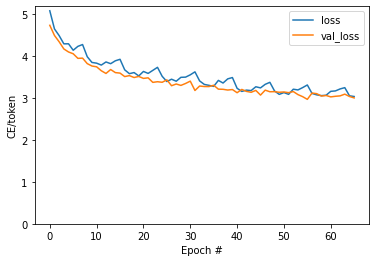

In [48]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

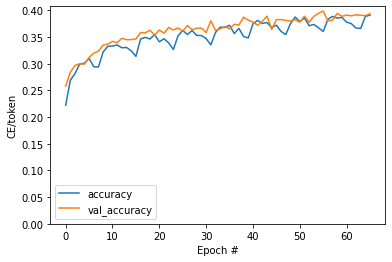

In [49]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

## Attention plots

Now, using the trained model,  run that `simple_gen` method on the image:

In [50]:
result = model.simple_gen(image, temperature=0.0)
result

'a man in a red wetsuit is surfing'

Split the output back into tokens:

In [51]:
str_tokens = result.split()
str_tokens.append('[END]')

The `DecoderLayers` each cache the attention scores for their `CrossAttention` layer. The shape of each attention map is `(batch=1, heads, sequence, image)`:

In [52]:
attn_maps = [layer.last_attention_scores for layer in model.decoder_layers]
[map.shape for map in attn_maps]

[TensorShape([1, 2, 9, 49]), TensorShape([1, 2, 9, 49])]

So stack the maps along the `batch` axis, then average over the `(batch, heads)` axes, while splitting the `image` axis back into `height, width`:


In [53]:
attention_maps = tf.concat(attn_maps, axis=0)
attention_maps = einops.reduce(
    attention_maps,
    'batch heads sequence (height width) -> sequence height width',
    height=7, width=7,
    reduction='mean')

Now you have a single attention map, for each sequence prediction. The values in each map should sum to `1.`

In [54]:
einops.reduce(attention_maps, 'sequence height width -> sequence', reduction='sum')

<tf.Tensor: shape=(9,), dtype=float32, numpy=
array([0.99999994, 1.        , 0.99999994, 0.99999994, 0.99999994,
       1.        , 0.99999994, 0.99999994, 0.99999994], dtype=float32)>

So here is where the model was focusing attention while generating each token of the output:

In [55]:
def plot_attention_maps(image, str_tokens, attention_map):
    fig = plt.figure(figsize=(16, 9))

    len_result = len(str_tokens)
    
    titles = []
    for i in range(len_result):
      map = attention_map[i]
      grid_size = max(int(np.ceil(len_result/2)), 2)
      ax = fig.add_subplot(3, grid_size, i+1)
      titles.append(ax.set_title(str_tokens[i]))
      img = ax.imshow(image)
      ax.imshow(map, cmap='gray', alpha=0.6, extent=img.get_extent(),
                clim=[0.0, np.max(map)])

    plt.tight_layout()

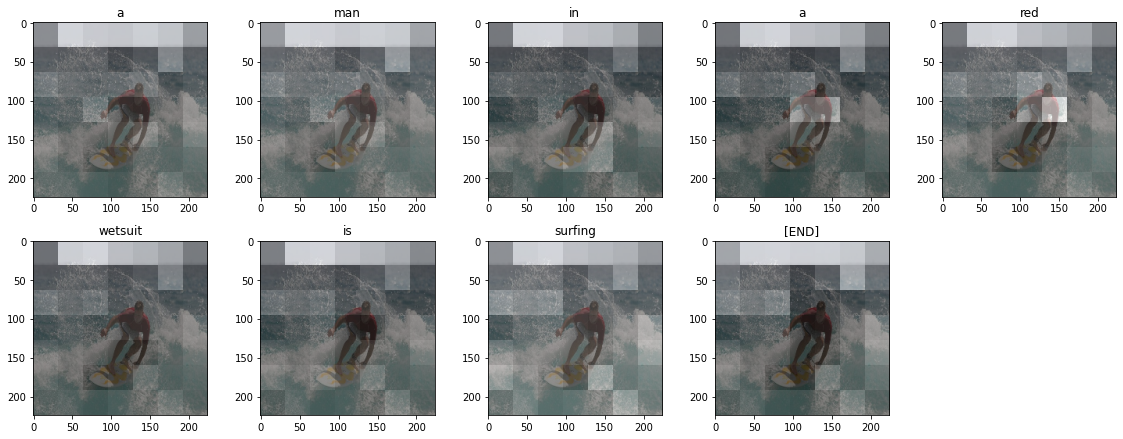

In [56]:
plot_attention_maps(image/255, str_tokens, attention_maps)

Now put that together into a more usable function:

In [57]:
@Captioner.add_method
def run_and_show_attention(self, image, temperature=0.0):
  result_txt = self.simple_gen(image, temperature)
  str_tokens = result_txt.split()
  str_tokens.append('[END]')

  attention_maps = [layer.last_attention_scores for layer in self.decoder_layers]
  attention_maps = tf.concat(attention_maps, axis=0)
  attention_maps = einops.reduce(
      attention_maps,
      'batch heads sequence (height width) -> sequence height width',
      height=7, width=7,
      reduction='mean')
  
  plot_attention_maps(image/255, str_tokens, attention_maps)
  t = plt.suptitle(result_txt)
  t.set_y(1.05)
  print()

## Try it on keyframes

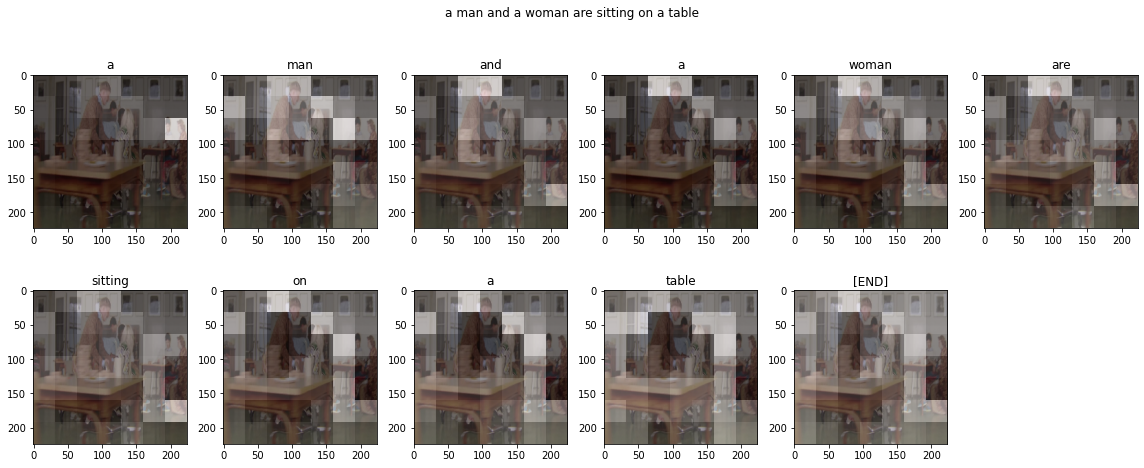

In [58]:
image_path = r"E:\J_vid\Frames\frame_710.jpg"
image = load_image(image_path)
#plt.plot(image)
run_and_show_attention(model, image)

**Summarizer**

In [4]:
import os

In [60]:
img_names = os.listdir(r"E:\J_vid\Frames")
img_names  = sorted(img_names, key=lambda x: int(x.split('_')[1].split('.')[0]))

In [61]:
text = ""

In [62]:
for i in img_names :
    image_path = "E:\J_vid\Frames\\"+ i 
    image = load_image(image_path)
    text = (text + model.simple_gen(image, temperature=0.0) + ". ")

In [63]:
print(text)

a person is walking down a snowy mountain. a large white truck is walking through the snow. a man in a blue shirt is standing in front of a building. a man in a white shirt is holding a baby. a man in a blue shirt is holding a microphone. a young girl in a dress is standing in front of a large building. a man in a black shirt is standing in front of a building. a man in a blue shirt is standing in front of a large crowd. a man in a black jacket is walking down a street. a man in a white shirt and a white hat is standing in front of a building. a man in a green shirt is standing in front of a large crowd. a man and a woman are sitting on a table. a woman is standing in front of a large display of a store. a woman in a dress is standing in front of a large building. a woman in a pink dress is standing in front of a large room. a man in a black shirt is standing in front of a white building. a young boy is holding a baby. a man in a white shirt is standing in front of a crowd. a man in a 

In [8]:
text = "a person is walking down a snowy mountain. a large white truck is walking through the snow. a man in a blue shirt is standing in front of a building. a man in a white shirt is holding a baby. a man in a blue shirt is holding a microphone. a young girl in a dress is standing in front of a large building. a man in a black shirt is standing in front of a building. a man in a blue shirt is standing in front of a large crowd. a man in a black jacket is walking down a street. a man in a white shirt and a white hat is standing in front of a building. a man in a green shirt is standing in front of a large crowd. a man and a woman are sitting on a table. a woman is standing in front of a large display of a store. a woman in a dress is standing in front of a large building. a woman in a pink dress is standing in front of a large room. a man in a black shirt is standing in front of a white building. a young boy is holding a baby. a man in a white shirt is standing in front of a crowd. a man in a red shirt is holding a microphone. a man in a black shirt is standing in front of a large crowd. "

In [9]:
pip install openai

Note: you may need to restart the kernel to use updated packages.Collecting openai
     -------------------------------------- 70.1/70.1 KB 767.4 kB/s eta 0:00:00
     -------------------------------------- 324.5/324.5 KB 2.5 MB/s eta 0:00:00
     ---------------------------------------- 56.9/56.9 KB 2.9 MB/s eta 0:00:00



You should consider upgrading via the 'c:\users\jhagan\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [10]:
import openai

In [24]:
openai.api_key = "sk-*******************************u8"

In [27]:
question = "remove errors from the paragraph : " + text

In [28]:
completion = openai.ChatCompletion.create(model="gpt-3.5-turbo", messages=[{"role": "user", "content": question}])
print(completion.choices[0].message.content)



Corrected paragraph: A person is walking down a snowy mountain. A large white truck is driving through the snow. A man in a blue shirt is standing in front of a building. A man in a white shirt is holding a baby. A man in a blue shirt is holding a microphone. A young girl in a dress is standing in front of a large building. A man in a black shirt is standing in front of a different building. A man in a blue shirt is standing in front of a large crowd. A man in a black jacket is walking down a street. A man in a white shirt and a white hat is standing in front of another building. A man in a green shirt is standing in front of another large crowd. A man and a woman are sitting on a table. A woman is standing in front of a display in a large store. A woman in a dress is standing in front of yet another large building. A woman in a pink dress is standing in front of a large room. A man in a black shirt is standing in front of a white building. A young boy is holding hands with a baby. A